# Process discriminator

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
torch.set_default_dtype(torch.double)
import sigkernel
from numpy.random import default_rng

Subroutines for test path generation.

**TODO : Migrate to sdeint to test in a much more general (and difficult) setting**

In [53]:
def generate_correlated_bms_with_timeline(cov, n_points = 100, rng = default_rng(69)):
    assert 0 <= cov <= 1
    
    cov_matrix = np.array([[1, cov],[cov, 1]])
    samples = rng.normal(size = (n_points, 2))
    correlated_samples = samples @ cov_matrix 
    
    dt = 1/np.sqrt(n_points)
    
    bm1 = dt * np.insert(correlated_samples[:, 0].cumsum(), 0, 0.)
    bm2 = dt * np.insert(correlated_samples[:, 1].cumsum(), 0, 0.)
    
    timeline = np.linspace(0, 1, n_points)
    
    return bm1[:-1], bm2[:-1], timeline

In [54]:
def generate_correlated_gbms_with_timeline(mu, sigma, cov, n_points = 100, rng = default_rng(69)):
    bm1, bm2, timeline = generate_correlated_bms_with_timeline(cov, n_points, rng)

    gbm1 = np.exp((mu - sigma ** 2 / 2.) * timeline + sigma * bm1)
    gbm2 = np.exp((mu - sigma ** 2 / 2.) * timeline + sigma * bm2)
    
    return gbm1, gbm2, timeline

In [72]:
def piecewise_linear_embedding_row_vct(path, time):
    assert len(path) == len(time), "Path and Time lengths must be equal"
    
    path = path.reshape(-1, 1)
    time = time.reshape(-1, 1)
    
    return np.concatenate((path, time), axis = 1)

In [73]:
def lead_lag_embedding_row_vct(path):
    path = path.reshape(-1, 1)
            
    return np.concatenate((path[1:], path[:-1]), axis = 1)

In [74]:
def generate_correlated_gbms_piecewise_lin(mu, sigma, cov, n_points = 100, rng = default_rng(69)):    
    gbm1, gbm2, timeline = generate_correlated_gbms_with_timeline(mu, sigma, cov, n_points, rng)    
    return piecewise_linear_embedding_row_vct(gbm1, timeline), piecewise_linear_embedding_row_vct(gbm2, timeline)

In [75]:
def generate_correlated_gbms_lead_lag(mu, sigma, cov, n_points = 100, rng = default_rng(69)):    
    gbm1, gbm2, timeline = generate_correlated_gbms_with_timeline(mu, sigma, cov, n_points + 1, rng)    
    return lead_lag_embedding_row_vct(gbm1), lead_lag_embedding_row_vct(gbm2)

In [76]:
sig1, sig2 = generate_correlated_gbms_piecewise_lin(0.02, 0.3, 0.5, 100)

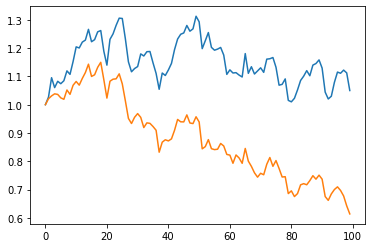

In [77]:
plt.plot(sig1[:, 0])
plt.plot(sig2[:, 0])

In [78]:
def generate_test_arrays(cov, mu = 0.02, sigma = 0.3, genf = generate_correlated_gbms_lead_lag, n_paths = 60, m_time_points = 100):
    a1 = []
    a2 = []
    
    rng = default_rng(69)
    
    for i in range(n_paths):
        sig1, sig2 = genf(0.02, 0.3, cov, m_time_points, rng)
        a1.append(sig1)
        a2.append(sig2)
    return torch.Tensor(a1), torch.Tensor(a2)

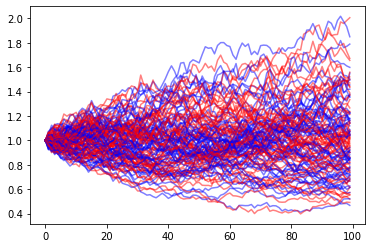

In [79]:
test_set_1, test_set_2 = generate_test_arrays(0.5) 

for i in range(len(test_set_1)):
    plt.plot(test_set_1[i, :, 1], "b", alpha=0.5)
    plt.plot(test_set_2[i, :, 1], "r", alpha=0.5)

In [104]:
test_set_1.shape

torch.Size([60, 100, 2])

# HSIC experiment

In [99]:
from itertools import product
import datetime
import pickle
import pprint

In [100]:
def HSIC_score_estimate(X, Y, dyadic_order = 1, static_kernel = sigkernel.RBFKernel(sigma=0.5)):
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)
    n = X.shape[0]
    
    kernelx_samples = torch.zeros(n,n)
    kernely_samples = torch.zeros(n,n)
    
    for i, j in tqdm(product(range(n), range(n))):
        kernelx_samples[i, j] = signature_kernel.compute_kernel(X[i:i+1, :, :], X[j:j+1, :, :])
        kernely_samples[i, j] = signature_kernel.compute_kernel(Y[i:i+1, :, :], Y[j:j+1, :, :])
    
    term1 = (kernelx_samples*kernely_samples).sum()/n**2
    term2 = -2/n**3*(torch.einsum('ij,ik->jk', kernelx_samples, kernely_samples)).sum()
    term3 = (kernelx_samples*kernely_samples.sum()).sum()/n**4
    
    return term1+term2+term3, (kernelx_samples*kernely_samples/n**2).var()

In [135]:
data_gen_fcts = [generate_correlated_gbms_lead_lag, generate_correlated_gbms_piecewise_lin]
static_kernels = [sigkernel.LinearKernel(), sigkernel.RBFKernel(sigma=0.5)]
dyadic_orders = [0, 1, 2, 3]
covs = np.linspace(0., 1., 10)

In [136]:
pp = pprint.PrettyPrinter(indent = 4)

In [137]:
results = []

for data_gen_fct, static_kernel, dyadic_order in product(data_gen_fcts, static_kernels, dyadic_orders):
    res_dict = {}
    
    res_dict['gen_fct'] = data_gen_fct.__name__
    res_dict['static_kernel'] = type(static_kernel)
    res_dict['dyadic_order'] = dyadic_order
    
    print("Starting:")
    pp.pprint(res_dict)
    
    scores = []
    variances = []
    for cov in covs:
        score, variance = HSIC_score_estimate(*generate_test_arrays(cov, genf = data_gen_fct), dyadic_order = dyadic_order, static_kernel = static_kernel)
        scores.append(score)
        variances.append(variance)

    res_dict['covs'] = covs.copy()
    res_dict['scores'] = scores
    res_dict['variances'] = variances
    results.append(res_dict)
    
    print("Finished.")
    pp.pprint(res_dict)

with open('results/{}.pickle'.format(datetime.datetime.today()).replace(' ', '_').replace(':', '.'), 'wb') as file:
    pickle.dump(results, file)

Starting:
{   'dyadic_order': 0,
    'gen_fct': 'generate_correlated_gbms_lead_lag',
    'static_kernel': <class 'sigkernel.sigkernel.LinearKernel'>}


3600it [00:08, 406.20it/s]
3600it [00:09, 381.91it/s]
3600it [00:08, 417.88it/s]
3600it [00:07, 452.92it/s]
3600it [00:07, 459.97it/s]
3600it [00:07, 457.98it/s]
3600it [00:07, 456.33it/s]
3600it [00:07, 460.17it/s]
3600it [00:07, 459.37it/s]
3600it [00:07, 451.56it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 0,
    'gen_fct': 'generate_correlated_gbms_lead_lag',
    'scores': [   tensor(0.0003),
                  tensor(0.0006),
                  tensor(0.0035),
                  tensor(0.0093),
                  tensor(0.0183),
                  tensor(0.0310),
                  tensor(0.0482),
                  tensor(0.0715),
                  tensor(0.1030),
                  tensor(0.1467)],
    'static_kernel': <class 'sigkernel.sigkernel.LinearKernel'>,
    'variances': [   tensor(5.4682e-09),
                     tensor(5.1257e-09),
                     tensor(5.9006e-09),
                     tensor(7.9623e-09),
                     tensor(1.1872e-08),
                     tensor(1.8883e-08),
                     tensor(3.1674e-08),
                     tensor(5.6081e-08),
                     tensor(1.054

3600it [00:11, 316.33it/s]
3600it [00:10, 338.64it/s]
3600it [00:10, 344.43it/s]
3600it [00:10, 353.66it/s]
3600it [00:10, 350.03it/s]
3600it [00:10, 328.20it/s]
3600it [00:11, 326.53it/s]
3600it [00:10, 357.32it/s]
3600it [00:10, 352.10it/s]
3600it [00:10, 353.73it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 1,
    'gen_fct': 'generate_correlated_gbms_lead_lag',
    'scores': [   tensor(0.0003),
                  tensor(0.0006),
                  tensor(0.0035),
                  tensor(0.0093),
                  tensor(0.0183),
                  tensor(0.0310),
                  tensor(0.0482),
                  tensor(0.0715),
                  tensor(0.1030),
                  tensor(0.1467)],
    'static_kernel': <class 'sigkernel.sigkernel.LinearKernel'>,
    'variances': [   tensor(5.4678e-09),
                     tensor(5.1254e-09),
                     tensor(5.9004e-09),
                     tensor(7.9619e-09),
                     tensor(1.1871e-08),
                     tensor(1.8881e-08),
                     tensor(3.1670e-08),
                     tensor(5.6070e-08),
                     tensor(1.053

3600it [00:35, 100.67it/s]
3600it [00:36, 99.47it/s] 
3600it [00:34, 104.16it/s]
3600it [00:35, 101.43it/s]
3600it [00:35, 100.94it/s]
3600it [00:38, 93.07it/s] 
3600it [00:37, 95.34it/s] 
3600it [00:38, 93.06it/s] 
3600it [00:35, 100.94it/s]
3600it [00:36, 98.96it/s] 


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 2,
    'gen_fct': 'generate_correlated_gbms_lead_lag',
    'scores': [   tensor(0.0003),
                  tensor(0.0006),
                  tensor(0.0035),
                  tensor(0.0093),
                  tensor(0.0183),
                  tensor(0.0310),
                  tensor(0.0482),
                  tensor(0.0715),
                  tensor(0.1030),
                  tensor(0.1467)],
    'static_kernel': <class 'sigkernel.sigkernel.LinearKernel'>,
    'variances': [   tensor(5.4677e-09),
                     tensor(5.1254e-09),
                     tensor(5.9003e-09),
                     tensor(7.9617e-09),
                     tensor(1.1870e-08),
                     tensor(1.8881e-08),
                     tensor(3.1668e-08),
                     tensor(5.6065e-08),
                     tensor(1.053

3600it [02:10, 27.48it/s]
3600it [02:11, 27.35it/s]
3600it [02:09, 27.77it/s]
3600it [01:59, 30.07it/s]
3600it [02:01, 29.66it/s]
3600it [01:58, 30.38it/s]
3600it [01:58, 30.33it/s]
3600it [01:59, 30.06it/s]
3600it [01:59, 30.13it/s]
3600it [01:58, 30.34it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 3,
    'gen_fct': 'generate_correlated_gbms_lead_lag',
    'scores': [   tensor(0.0003),
                  tensor(0.0006),
                  tensor(0.0035),
                  tensor(0.0093),
                  tensor(0.0183),
                  tensor(0.0310),
                  tensor(0.0482),
                  tensor(0.0715),
                  tensor(0.1030),
                  tensor(0.1467)],
    'static_kernel': <class 'sigkernel.sigkernel.LinearKernel'>,
    'variances': [   tensor(5.4677e-09),
                     tensor(5.1253e-09),
                     tensor(5.9002e-09),
                     tensor(7.9617e-09),
                     tensor(1.1870e-08),
                     tensor(1.8880e-08),
                     tensor(3.1667e-08),
                     tensor(5.6063e-08),
                     tensor(1.053

3600it [00:09, 388.99it/s]
3600it [00:09, 391.05it/s]
3600it [00:09, 390.51it/s]
3600it [00:09, 392.53it/s]
3600it [00:09, 383.85it/s]
3600it [00:09, 375.56it/s]
3600it [00:09, 391.04it/s]
3600it [00:09, 388.81it/s]
3600it [00:09, 390.71it/s]
3600it [00:09, 393.19it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 0,
    'gen_fct': 'generate_correlated_gbms_lead_lag',
    'scores': [   tensor(0.0053),
                  tensor(0.0057),
                  tensor(0.0144),
                  tensor(0.0326),
                  tensor(0.0623),
                  tensor(0.1069),
                  tensor(0.1714),
                  tensor(0.2634),
                  tensor(0.3949),
                  tensor(0.5846)],
    'static_kernel': <class 'sigkernel.sigkernel.RBFKernel'>,
    'variances': [   tensor(4.6555e-08),
                     tensor(4.2459e-08),
                     tensor(5.3234e-08),
                     tensor(8.3570e-08),
                     tensor(1.4701e-07),
                     tensor(2.7505e-07),
                     tensor(5.4113e-07),
                     tensor(1.1233e-06),
                     tensor(2.4617e-

3600it [00:11, 318.15it/s]
3600it [00:11, 311.66it/s]
3600it [00:11, 317.00it/s]
3600it [00:11, 312.59it/s]
3600it [00:11, 312.55it/s]
3600it [00:11, 312.60it/s]
3600it [00:11, 308.03it/s]
3600it [00:11, 317.17it/s]
3600it [00:11, 314.34it/s]
3600it [00:11, 312.93it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 1,
    'gen_fct': 'generate_correlated_gbms_lead_lag',
    'scores': [   tensor(0.0053),
                  tensor(0.0057),
                  tensor(0.0144),
                  tensor(0.0326),
                  tensor(0.0623),
                  tensor(0.1069),
                  tensor(0.1714),
                  tensor(0.2636),
                  tensor(0.3953),
                  tensor(0.5858)],
    'static_kernel': <class 'sigkernel.sigkernel.RBFKernel'>,
    'variances': [   tensor(4.6551e-08),
                     tensor(4.2460e-08),
                     tensor(5.3240e-08),
                     tensor(8.3587e-08),
                     tensor(1.4705e-07),
                     tensor(2.7518e-07),
                     tensor(5.4155e-07),
                     tensor(1.1248e-06),
                     tensor(2.4677e-

3600it [00:24, 146.35it/s]
3600it [00:24, 149.26it/s]
3600it [00:24, 149.08it/s]
3600it [00:24, 146.90it/s]
3600it [00:24, 148.95it/s]
3600it [00:24, 145.26it/s]
3600it [00:24, 148.60it/s]
3600it [00:24, 146.73it/s]
3600it [00:24, 147.61it/s]
3600it [00:24, 148.32it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 2,
    'gen_fct': 'generate_correlated_gbms_lead_lag',
    'scores': [   tensor(0.0053),
                  tensor(0.0057),
                  tensor(0.0144),
                  tensor(0.0326),
                  tensor(0.0623),
                  tensor(0.1069),
                  tensor(0.1714),
                  tensor(0.2635),
                  tensor(0.3953),
                  tensor(0.5857)],
    'static_kernel': <class 'sigkernel.sigkernel.RBFKernel'>,
    'variances': [   tensor(4.6546e-08),
                     tensor(4.2457e-08),
                     tensor(5.3236e-08),
                     tensor(8.3578e-08),
                     tensor(1.4703e-07),
                     tensor(2.7513e-07),
                     tensor(5.4142e-07),
                     tensor(1.1245e-06),
                     tensor(2.4668e-

3600it [02:03, 29.23it/s]
3600it [01:21, 44.17it/s]
3600it [01:23, 42.89it/s]
3600it [01:23, 42.86it/s]
3600it [01:24, 42.79it/s]
3600it [01:23, 42.88it/s]
3600it [01:24, 42.58it/s]
3600it [01:24, 42.66it/s]
3600it [01:23, 42.90it/s]
3600it [01:24, 42.79it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 3,
    'gen_fct': 'generate_correlated_gbms_lead_lag',
    'scores': [   tensor(0.0053),
                  tensor(0.0057),
                  tensor(0.0144),
                  tensor(0.0326),
                  tensor(0.0623),
                  tensor(0.1069),
                  tensor(0.1714),
                  tensor(0.2635),
                  tensor(0.3952),
                  tensor(0.5857)],
    'static_kernel': <class 'sigkernel.sigkernel.RBFKernel'>,
    'variances': [   tensor(4.6544e-08),
                     tensor(4.2455e-08),
                     tensor(5.3234e-08),
                     tensor(8.3575e-08),
                     tensor(1.4702e-07),
                     tensor(2.7511e-07),
                     tensor(5.4136e-07),
                     tensor(1.1243e-06),
                     tensor(2.4663e-

3600it [00:05, 695.40it/s]
3600it [00:05, 716.60it/s]
3600it [00:05, 714.95it/s]
3600it [00:05, 708.89it/s]
3600it [00:05, 699.91it/s]
3600it [00:05, 702.17it/s]
3600it [00:05, 709.10it/s]
3600it [00:05, 705.47it/s]
3600it [00:05, 711.49it/s]
3600it [00:05, 710.13it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 0,
    'gen_fct': 'generate_correlated_gbms_piecewise_lin',
    'scores': [   tensor(0.0015),
                  tensor(0.0056),
                  tensor(0.0138),
                  tensor(0.0286),
                  tensor(0.0557),
                  tensor(0.1083),
                  tensor(0.2215),
                  tensor(0.4964),
                  tensor(1.2557),
                  tensor(3.6363)],
    'static_kernel': <class 'sigkernel.sigkernel.LinearKernel'>,
    'variances': [   tensor(2.0511e-08),
                     tensor(3.2987e-08),
                     tensor(6.5731e-08),
                     tensor(1.6211e-07),
                     tensor(5.0154e-07),
                     tensor(1.9497e-06),
                     tensor(9.4228e-06),
                     tensor(5.6133e-05),
                     tensor(

3600it [00:06, 519.17it/s]
3600it [00:08, 436.43it/s]
3600it [00:08, 441.34it/s]
3600it [00:08, 438.01it/s]
3600it [00:08, 441.20it/s]
3600it [00:08, 425.11it/s]
3600it [00:08, 439.33it/s]
3600it [00:08, 438.77it/s]
3600it [00:08, 440.57it/s]
3600it [00:08, 439.76it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 1,
    'gen_fct': 'generate_correlated_gbms_piecewise_lin',
    'scores': [   tensor(0.0015),
                  tensor(0.0056),
                  tensor(0.0138),
                  tensor(0.0286),
                  tensor(0.0557),
                  tensor(0.1082),
                  tensor(0.2211),
                  tensor(0.4949),
                  tensor(1.2496),
                  tensor(3.6089)],
    'static_kernel': <class 'sigkernel.sigkernel.LinearKernel'>,
    'variances': [   tensor(2.0508e-08),
                     tensor(3.2978e-08),
                     tensor(6.5695e-08),
                     tensor(1.6195e-07),
                     tensor(5.0066e-07),
                     tensor(1.9441e-06),
                     tensor(9.3796e-06),
                     tensor(5.5738e-05),
                     tensor(

3600it [00:16, 220.08it/s]
3600it [00:16, 219.53it/s]
3600it [00:16, 219.94it/s]
3600it [00:16, 220.12it/s]
3600it [00:16, 220.99it/s]
3600it [00:16, 216.79it/s]
3600it [00:16, 219.88it/s]
3600it [00:16, 220.57it/s]
3600it [00:16, 214.36it/s]
3600it [00:16, 219.48it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 2,
    'gen_fct': 'generate_correlated_gbms_piecewise_lin',
    'scores': [   tensor(0.0015),
                  tensor(0.0056),
                  tensor(0.0138),
                  tensor(0.0286),
                  tensor(0.0557),
                  tensor(0.1082),
                  tensor(0.2210),
                  tensor(0.4945),
                  tensor(1.2477),
                  tensor(3.6001)],
    'static_kernel': <class 'sigkernel.sigkernel.LinearKernel'>,
    'variances': [   tensor(2.0507e-08),
                     tensor(3.2975e-08),
                     tensor(6.5684e-08),
                     tensor(1.6190e-07),
                     tensor(5.0039e-07),
                     tensor(1.9424e-06),
                     tensor(9.3664e-06),
                     tensor(5.5616e-05),
                     tensor(

3600it [01:23, 43.37it/s]
3600it [01:23, 43.23it/s]
3600it [01:22, 43.39it/s]
3600it [01:22, 43.44it/s]
3600it [01:23, 43.26it/s]
3600it [01:29, 40.26it/s]
3600it [01:24, 42.80it/s]
3600it [01:23, 43.02it/s]
3600it [01:23, 43.17it/s]
3600it [01:23, 43.11it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 3,
    'gen_fct': 'generate_correlated_gbms_piecewise_lin',
    'scores': [   tensor(0.0015),
                  tensor(0.0056),
                  tensor(0.0138),
                  tensor(0.0286),
                  tensor(0.0557),
                  tensor(0.1082),
                  tensor(0.2209),
                  tensor(0.4944),
                  tensor(1.2472),
                  tensor(3.5977)],
    'static_kernel': <class 'sigkernel.sigkernel.LinearKernel'>,
    'variances': [   tensor(2.0507e-08),
                     tensor(3.2975e-08),
                     tensor(6.5681e-08),
                     tensor(1.6189e-07),
                     tensor(5.0032e-07),
                     tensor(1.9419e-06),
                     tensor(9.3628e-06),
                     tensor(5.5583e-05),
                     tensor(

3600it [00:05, 619.56it/s]
3600it [00:05, 631.69it/s]
3600it [00:05, 617.97it/s]
3600it [00:05, 622.69it/s]
3600it [00:05, 625.91it/s]
3600it [00:05, 627.95it/s]
3600it [00:05, 616.09it/s]
3600it [00:05, 610.64it/s]
3600it [00:05, 616.16it/s]
3600it [00:05, 615.96it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 0,
    'gen_fct': 'generate_correlated_gbms_piecewise_lin',
    'scores': [   tensor(0.0237),
                  tensor(0.0548),
                  tensor(0.1220),
                  tensor(0.2300),
                  tensor(0.3889),
                  tensor(0.6230),
                  tensor(0.9914),
                  tensor(1.6374),
                  tensor(2.9097),
                  tensor(5.6545)],
    'static_kernel': <class 'sigkernel.sigkernel.RBFKernel'>,
    'variances': [   tensor(1.7666e-06),
                     tensor(2.0329e-06),
                     tensor(2.6896e-06),
                     tensor(4.3292e-06),
                     tensor(9.0165e-06),
                     tensor(2.4547e-05),
                     tensor(8.2971e-05),
                     tensor(0.0003),
                     tensor(0.0015)

3600it [00:07, 462.72it/s]
3600it [00:09, 397.62it/s]
3600it [00:09, 395.54it/s]
3600it [00:09, 397.51it/s]
3600it [00:09, 391.29it/s]
3600it [00:09, 397.68it/s]
3600it [00:09, 397.42it/s]
3600it [00:09, 399.10it/s]
3600it [00:09, 397.72it/s]
3600it [00:08, 401.30it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 1,
    'gen_fct': 'generate_correlated_gbms_piecewise_lin',
    'scores': [   tensor(0.0237),
                  tensor(0.0548),
                  tensor(0.1219),
                  tensor(0.2299),
                  tensor(0.3889),
                  tensor(0.6230),
                  tensor(0.9915),
                  tensor(1.6390),
                  tensor(2.9194),
                  tensor(5.7036)],
    'static_kernel': <class 'sigkernel.sigkernel.RBFKernel'>,
    'variances': [   tensor(1.7665e-06),
                     tensor(2.0327e-06),
                     tensor(2.6888e-06),
                     tensor(4.3268e-06),
                     tensor(9.0092e-06),
                     tensor(2.4528e-05),
                     tensor(8.2983e-05),
                     tensor(0.0003),
                     tensor(0.0015)

3600it [00:17, 204.96it/s]
3600it [00:17, 207.39it/s]
3600it [00:17, 207.00it/s]
3600it [00:17, 207.22it/s]
3600it [00:17, 205.25it/s]
3600it [00:17, 207.76it/s]
3600it [00:17, 207.18it/s]
3600it [00:17, 204.72it/s]
3600it [00:17, 207.52it/s]
3600it [00:17, 206.89it/s]


Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 2,
    'gen_fct': 'generate_correlated_gbms_piecewise_lin',
    'scores': [   tensor(0.0237),
                  tensor(0.0548),
                  tensor(0.1219),
                  tensor(0.2299),
                  tensor(0.3888),
                  tensor(0.6228),
                  tensor(0.9910),
                  tensor(1.6378),
                  tensor(2.9165),
                  tensor(5.6973)],
    'static_kernel': <class 'sigkernel.sigkernel.RBFKernel'>,
    'variances': [   tensor(1.7664e-06),
                     tensor(2.0326e-06),
                     tensor(2.6883e-06),
                     tensor(4.3250e-06),
                     tensor(9.0022e-06),
                     tensor(2.4498e-05),
                     tensor(8.2840e-05),
                     tensor(0.0003),
                     tensor(0.0015)

3600it [01:24, 42.51it/s]
3600it [01:23, 42.92it/s]
3600it [01:24, 42.77it/s]
3600it [01:24, 42.69it/s]
3600it [01:23, 42.89it/s]
3600it [01:24, 42.38it/s]
3600it [01:24, 42.84it/s]
3600it [01:23, 42.90it/s]
3600it [01:24, 42.65it/s]
3600it [01:24, 42.77it/s]

Finished.
{   'covs': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
    'dyadic_order': 3,
    'gen_fct': 'generate_correlated_gbms_piecewise_lin',
    'scores': [   tensor(0.0237),
                  tensor(0.0548),
                  tensor(0.1219),
                  tensor(0.2299),
                  tensor(0.3888),
                  tensor(0.6227),
                  tensor(0.9908),
                  tensor(1.6373),
                  tensor(2.9152),
                  tensor(5.6934)],
    'static_kernel': <class 'sigkernel.sigkernel.RBFKernel'>,
    'variances': [   tensor(1.7664e-06),
                     tensor(2.0325e-06),
                     tensor(2.6881e-06),
                     tensor(4.3244e-06),
                     tensor(8.9999e-06),
                     tensor(2.4487e-05),
                     tensor(8.2786e-05),
                     tensor(0.0003),
                     tensor(0.0015)